# 梯度下降算法

首先我让Chatgpt教我梯度下降的原理，总结如下：

1. 目标：最小化损失函数
2. 梯度：是一个向量，沿着该向量方向，函数值上升速度最快；逆着该方向，函数值下降速度最快
3. 步骤
   - 初始化参数
   - 计算损失函数
   - 更新参数向量：$\mathbf{x}_n=\mathbf{x}_{n-1}-\alpha\nabla f(\mathbf{x}_{n-1})$
   - 重复前两个步骤直到损失函数值收敛 / 迭代到一定次数
4. 梯度下降种类
   - Batch Gradient Descent
   - Stochastic Gradient Descent (SGD)
   - Mini-Batch Gradient Descent
   
   区别参考这篇[博客](https://xilinx.eetrend.com/content/2018/100012898.html)，我们这里使用SGD
5. 挑战
   - 学习率$\alpha$的选取
   - 局部最小值
   - 鞍点
   - 极大/极小的梯度

# 求$\sqrt[4]{9}$

定义损失函数

$$
L(x)=\frac 12(x^n-y)^2
$$

本题中$y=9,n=4$

满足$x^4=9$的$x$一定使损失函数$L(x)$最小，问题转化为如何找到对应的$x$。
使用梯度下降算法，表达式为

$$
x_{n+1}=x_n-\alpha L'(x_n)
$$

本题的梯度公式为

$$
\begin{aligned}
L'(x)&=nx^{n-1}(x^n-y)\\
&=4x^3(x^4-9)
\end{aligned}
$$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


因$2^4=16>9$，$1^4=1<9$，故选取$x_0=2$作为初始值。这里我让gd函数每次迭代都做一个判断，以此确定精度。使用函数时可以把参数`iter`设成非常大也没关系，因为只要达到精度要求就会break。这里把精度设做$0.001$，即得到结果$x$对应的损失函数满足$L(x)<0.001$

In [61]:
def L(x):
    return 1/2 * (x**4-9)**2
    
def g(x): # gradient
    return 4 * x**3 * (x**4 - 9)
    
def gd(a, iter): # gradient descent (alpha, iteration)
    x = 2
    for i in range(iter):
        G = g(x)
        x = x - a * G
        if L(x) < 0.001: # 精度
            break
        #print(f"iterate {i+1}: x: {x}, L(x): {L(x)}")
    return x, L(x), i

In [50]:
print(gd(0.01,100))
print(g(0.01))

(-0.2978279578453934, 40.4292193594515, 99)
-3.599999996e-05


这个不对，应该是`g(2)`太大，`x`直接跑到负半轴上去了，卡在0附近出不来。画个图

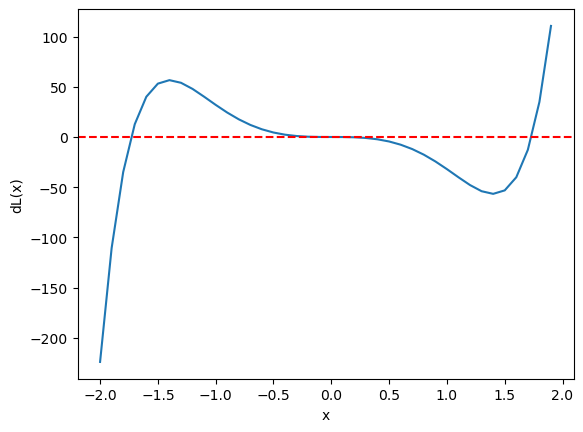

In [51]:
t = np.arange(-2,2,0.1)
g = [g(x) for x in t]
plt.plot(t,g,label='L(x)')
plt.xlabel('x')
plt.ylabel('dL(x)')
plt.axhline(0, color = 'red', linestyle = '--')

所以初始值的选取还是蛮重要，或者说$\alpha$的选择很重要，如果换成$\alpha=0.00001$试试看能不能解决。

In [54]:
gd(0.0001,100000)

(1.7341658743801722, 0.0009698236396213781, 95)

在$L(x)<0.001$下，我们找到
$$
\sqrt[4]{9}=1.734
$$

下面分别试试$a=0.01,0.001,0.0001,0.00001$四种学习率，并分别画出学习过程，即损失函数随迭代次数的变化图。定义一个新函数

In [83]:
loss = np.zeros(100) 
def learn(x,a): # 第一项是初始值，第二项是学习率
    n = 100 # 统一迭代100次
    for i in range(n):
        G = 4 * x**3 * (x**4 - 9)
        loss[i] = 1/2 * (x**4-9)**2
        x = x - a * G

    return loss

## $a = 0.01$

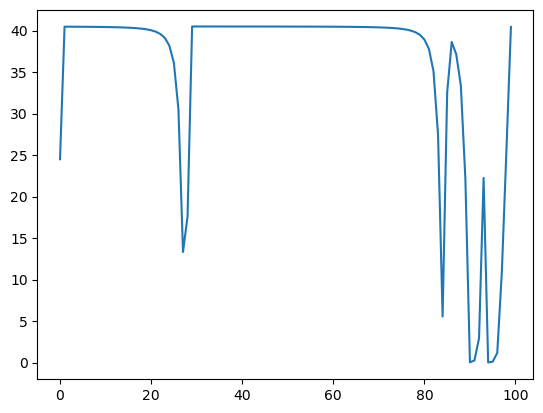

In [85]:
plt.plot(list(range(100)),learn(2,0.01))

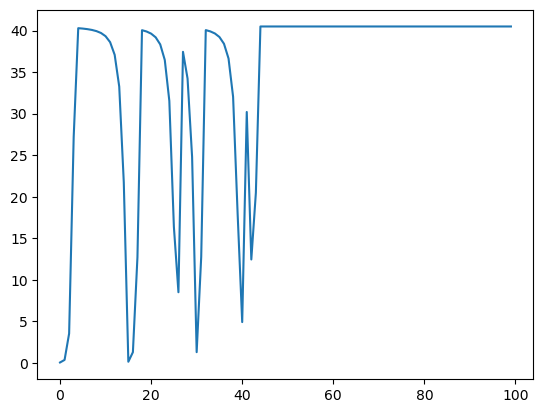

In [86]:
plt.plot(list(range(100)),learn(1.72,0.01))

可见不是初始值的问题

## $a=0.001$

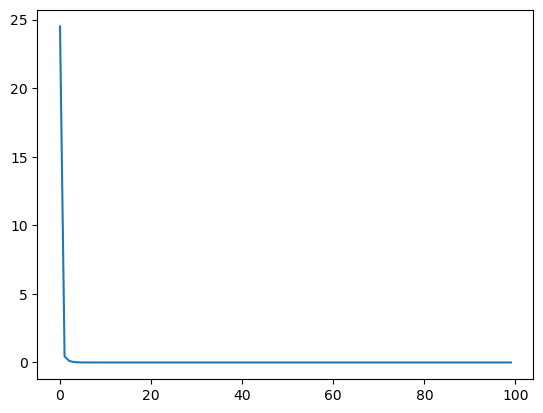

In [90]:
plt.plot(list(range(100)),learn(2,0.001))

收敛得非常快，可以看到仅迭代$6$次就达到$L(x)<0.001$

In [91]:
gd(0.001,100)

(1.7332675664374257, 0.0003204630846572564, 6)

## $a=0.0001$

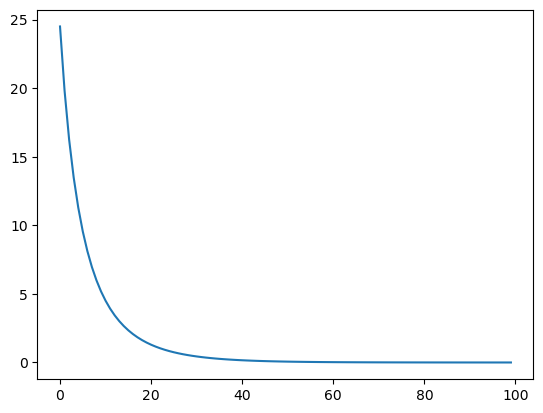

In [92]:
plt.plot(list(range(100)),learn(2,0.0001))

In [93]:
gd(0.0001,100)

(1.7341658743801722, 0.0009698236396213781, 95)

收敛得慢了

## $a=0.00001$

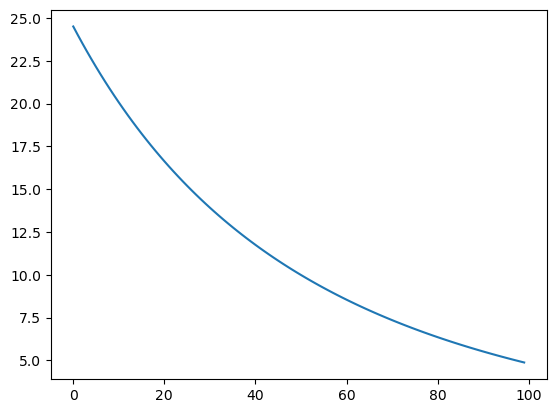

In [96]:
plt.plot(list(range(100)),learn(2,0.00001))

In [98]:
gd(0.00001,1000)

(1.7341946802044879, 0.0009964699596599097, 981)

现在收敛得更慢了。其实是意料之中，因为$\alpha$小说明每一次迭代$x$挪动的距离小，逼近真实值的速度慢

# 使用scipy.optimize

以下部分大量使用Chatgpt作学习工具

## `minimize_scalar`

这个函数默认用的是Brent方法，它是一种使用三种不同数值优化技术（黄金分割、抛物线插值和二分法）的混合方法，通常对大多数一维函数表现得很好，特别是对于不可导函数和非凸函数。其余还有
- Golden
- Bounded
- Bracket
- Nelder-Mead
- Powell

In [113]:
# Chatgpt示例：
import numpy as np
from scipy.optimize import minimize_scalar

# 定义目标函数
def objective_function(x):
    return x**2 + 5*x + 6

# 使用 minimize_scalar 最小化目标函数
result = minimize_scalar(objective_function)

# 输出最优解和最小值
print("Optimal Solution:", result.x)
print("Minimum Value:", result.fun)

Optimal Solution: -2.5
Minimum Value: -0.25


套用在$L(x)$中，太精确了

In [119]:
def L(x):
    return 1/2 * (x**4-9)**2

result = minimize_scalar(L)
print(result)

 message: 
          Optimization terminated successfully;
          The returned value satisfies the termination criteria
          (using xtol = 1.48e-08 )
 success: True
     fun: 3.637607713008491e-15
       x: 1.7320508116726288
     nit: 13
    nfev: 16


## 使用BFGS

全名Broyden-Fletcher-Goldfarb-Shanno，用于解决无约束的多维优化问题。它是拟牛顿法（Quasi-Newton）的一种，旨在寻找目标函数的最小值。相比于`minimize_scalar`，缺点是要给出初始值

In [117]:
from scipy.optimize import minimize
bfgs = minimize(L, 2, method='bfgs')
print(f"x={bfgs.x}, L={bfgs.fun}")

x=[1.7320508], L=1.1993374353224593e-14


## 使用Newton-CG

通常用于求解无约束的多维优化问题，这一点和BFGS相同。它基于牛顿法的变种，具体地说，它使用共轭梯度（Conjugate Gradient）方法来逼近牛顿法的步骤，因此得名 "Newton-CG"。这个算法的主要目标是寻找目标函数的最小值。

In [122]:
def g(x): # gradient
    return 4 * x**3 * (x**4 - 9)

cg = minimize(L, 2, jac=g, method='newton-cg')
print(f"x={cg.x}, L={cg.fun}")

x=[1.73205081], L=1.9635447486648619e-19
